### CNN Feature Based Image Copy Detection With Contextual Hash Embeddings
paper [here](https://www.mdpi.com/2227-7390/8/7/1172/pdf)

Dataset [[here]](http://lear.inrialpes.fr/people/jegou/data.php#copydays)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import torch
from torchvision import models
import torchvision.transforms as transforms

import os
import cv2
import numpy as np
import sklearn
from sklearn import preprocessing

In [ ]:
#using Pretrained model
model = models.alexnet(pretrained = True)
model = list(model.children())[0][:12]
model = model.eval()

In [ ]:
model #model Architecture

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
)

In [ ]:
#function for generating Hash sequences

def hash_point(pt,arr,r,c):
   if r < 0 or c < 0 or r > 3 or c > 3:
       return 0
   else:
       npt = arr[r][c]
       return 1 if pt < npt else 0
       
def hash_gen(g,i,j):
   neighborhood = [(i-1,j),(i-1,j-1),(i,j-1),(i+1,j-1),(i+1,j),(i+1,j+1),(i,j+1),(i-1,j+1)]
   pt = g[i][j]
   for nbd in neighborhood:
       yield hash_point(pt,g,*nbd)

def che_gen(g):
   for i in range(4):
       for j in range(4):
           yield hash_gen(g,i,j)

In [ ]:
#Dividing Image into Slices
def get_blocks(cord,radius,path):
    max_loc = cord
    circle_radius = radius

    img = cv2.imread(path,0)
    
    image_array = img.copy()
    mask = np.zeros(image_array.shape, dtype=np.uint8)
    cv2.circle(mask, max_loc, circle_radius, (255, 255, 255), -1, 8, 0)

    result_array = image_array & mask

    # Crop/center result (assuming max_loc is of the form (x, y))
    result_array1 = result_array[max(0,max_loc[1] - circle_radius):max(0,max_loc[1] + circle_radius),
                             max(0,max_loc[0] - circle_radius):max(0,max_loc[0] + circle_radius)]

    #convert to log polar space
    log_polar = cv2.logPolar(result_array1,(radius,radius),circle_radius,1)

    
    #divide into bllocks
    log_polar_gray  = log_polar
    M = int(log_polar_gray.shape[0]/4)
    N = int(log_polar_gray.shape[1]/4)

    slices = []
    for j in range(4):
        for i in range(4):
            if j!=3 and i!=3: #center
                slices.append(log_polar_gray[j*N:j*N+N,i*M:i*M+M])
            if j!=3 and i == 3: #top right corner
                slices.append(log_polar_gray[j*N:j*N+N,i*M:])
            if j == 3 and i!=3: #bottom down
                slices.append(log_polar_gray[j*N:,i*M:i*M+M])
            if j==3 and i ==3: #bottom corner
                slices.append(log_polar_gray[j*N:,i*M:])
    
    return slices
    

In [ ]:
#for getting keypoints and radius
def get_coordinates_and_radius(keypoints_orb):
    keys = []
    for i in keypoints_orb:
        cord = [int(i) for i in i.pt]
        rad = int(i.size/2)
        keys.append([tuple(cord),rad])
    return keys

### CFM_LocalCNNFeatures_Hashembedding

In [ ]:
files_path="gdrive/My Drive/copy_detection/ours_croped_scaled/"
val =sorted([int(i.split(".")[0]) for i in os.listdir(files_path)]) #os.listdir wont give you file order
images = [str(i)+".jpg" for i in val] #getting files in order

total_images_features = []
total_images_hash_values = []
for i in images:
    #reading image
    img = cv2.imread(files_path+i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    #image to alexnet to get CFMs
    data_transform = transforms.ToTensor()
    img1 = data_transform(img)
    img2 = img1.unsqueeze(0)
    op = model1(img2.cuda())
    output = np.array(op.detach().cpu().numpy()[0]) #1,256,height,width
    
    #calculating image and cfm areas for ratio
    img_area = img.shape[0]*img.shape[1]
    cfm_area = output.shape[1]*output.shape[2] 
    area_ratio = cfm_area/img_area
    
    #passing image to ORB
    orb = cv2.ORB_create(nfeatures=1500)
    keypoints_orb = orb.detect(img, None) #change
    keypoints = get_coordinates_and_radius(keypoints_orb)
    
    
    #Scaling CFM radius and coordinates
    cfm_radius = []
    cfm_coo = []
    for key in keypoints:
        cfm_radius.append(np.float32(area_ratio*key[1]))
        
        cfm_x = (output.shape[1]*key[0][0])/img.shape[0]
        cfm_y = (output.shape[2]*key[0][1])/img.shape[1]
        cfm_coo.append((np.float32(cfm_x),np.float32(cfm_y)))

    #Finding normalized radius from Minimum of 1 to B value
    val = [key[1] for key in keypoints]    
    x = np.array(cfm_radius)
    b = (max(val)-min(val))/(min(val))
    a = 1
    normalized_radius=(b-a)*((x-x.min())/(x.max()-x.min()))+a
    
    #For finding local CNN features(mapping keypoints to CFM)
    all_keypoint_features = []
    output = np.array(op.detach().cpu().numpy()[0])
    for cord,rad in zip(cfm_coo,normalized_radius):
        feature_map = []
        for fmap in range(len(output)):
            op = np.sum(output[fmap][int(cord[0]):int(cord[0])+int(rad),int(cord[1]):int(cord[1])+int(rad)])
            feature_map.append(op)
        op1 = np.array(feature_map).reshape(1,256)
        norm_final = sklearn.preprocessing.normalize(op1, norm='l2', axis=1, copy=True, return_norm=False)
        all_keypoint_features.append(norm_final)    
    
    #stacking all keypoints(ex:400) of a single image
    keypoint_feat = all_keypoint_features[0]
    for keypoint in all_keypoint_features[1:]:
        keypoint_feat = np.vstack((keypoint_feat,keypoint))
    
    print(keypoint_feat.shape)#(483,256)(500,256) 256 columns fixed
    total_images_features.append(keypoint_feat)
    
    #multiplying radius with Alpha 3.2
    expanded_radius = []
    for key,radius in keypoints:
        expand_r = int(int(radius/2)*3.2)
        expanded_radius.append(expand_r)
    
    cords = []
    for cord,radius in keypoints:
        cords.append(cord)
    
    #get Hash Values
    all_hash_values = []
    for cord,ex_radius in zip(cords,expanded_radius):
        slices = get_blocks(cord,radius,files_path+i)
        grey_intensities = np.array([np.mean(i) for i in slices]).reshape(4,4)
        hash_val = get_hash_embedding(grey_intensities)
        all_hash_values.append(hash_val)
    
    total_images_hash_values.append(all_hash_values)

(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)
(1500, 256)


In [ ]:
import numpy
numpy.savez('gdrive/My Drive/copy_detection/scaled_vector_data.npz', a=total_images_hash_values, b=total_images_features)

In [ ]:
# import numpy
# vet = numpy.load('gdrive/My Drive/copy_detection/scaled_vector_data.npz', allow_pickle= True)
# total_images_hash_values1 = vet['a']
# total_images_features1 = vet['b']

In [ ]:
#stacking all images all keypoints in to a single vector
img_feat = total_images_features[0]
for i in total_images_features[1:]:
    img_feat = np.vstack((img_feat,i))
    
print(img_feat.shape)

(42000, 256)


### 3. Local_CNN_VBOW

In [ ]:
import scipy
import random

random.seed(101)

from scipy.cluster.vq import kmeans,vq #vq stands for vector quantization
k= 100 #maximum clusters can be 50
                                           

voc1,variance=kmeans(img_feat,k)        #voc decides no of clusters to be formed, based on distace
                                           # 50 is no of iterations

#clustering all the keypoints of all images
database_words = []
im_features=np.zeros((len(os.listdir(files_path)),k),"float32")
for i in range(len(os.listdir(files_path))):
    words1,distance=vq(total_images_features[i],voc1) #vector quantization
    database_words.append(words1)
    for w in words1:
        im_features[i][w]+=1

### querry_image

In [ ]:
import os
#lets take a sample image
path = "gdrive/My Drive/copy_detection/ours_croped_scaled/20.jpg"
from PIL import Image
Image.open(path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from torchvision import transforms
file = Image.open(path)

data_transform = transforms.ToTensor()
img1 = data_transform(file)
op = model1(img1.unsqueeze(0).cuda())

In [ ]:
output = np.array(op.detach().cpu().numpy()[0]) #1,256,height,width

In [ ]:
import cv2
img = cv2.imread(path)

In [ ]:
orb = cv2.ORB_create(nfeatures=1500)
keypoints_orb, descriptors = orb.detectAndCompute(img, None)

keypoints = get_coordinates_and_radius(keypoints_orb)

In [ ]:
#Scaling CFM radius and coordinates
cfm_radius = []
cfm_coo = []
for key in keypoints:
    cfm_radius.append(np.float32(area_ratio*key[1]))

    cfm_x = (output.shape[1]*key[0][0])/img.shape[0]
    cfm_y = (output.shape[2]*key[0][1])/img.shape[1]
    cfm_coo.append((np.float32(cfm_x),np.float32(cfm_y)))

#Finding normalized radius from Minimum of 1 to B value
val = [key[1] for key in keypoints]    
x = np.array(cfm_radius)
b = (max(val)-min(val))/(min(val))
#     print(b)
a = 1
normalized_radius=(b-a)*((x-x.min())/(x.max()-x.min()))+a

In [ ]:
all_keypoint_features = []
output = np.array(op.detach().cpu().numpy()[0])
for cord,rad in zip(cfm_coo,normalized_radius):
    feature_map = []
    for fmap in range(len(output)):
        op = np.sum(output[fmap][int(cord[0]):int(cord[0])+int(rad),int(cord[1]):int(cord[1])+int(rad)])
        feature_map.append(op)
    op1 = np.array(feature_map).reshape(1,256)
    norm_final = sklearn.preprocessing.normalize(op1, norm='l2', axis=1, copy=True, return_norm=False)
    all_keypoint_features.append(norm_final)    
#     print(all_keypoint_features[0].shape)#(1,256)


In [ ]:
keypoint_feat = all_keypoint_features[0]
for keypoint in all_keypoint_features[1:]:
    keypoint_feat = np.vstack((keypoint_feat,keypoint))

In [ ]:
keypoint_feat.shape #324 keypoints only for a test image

(1500, 256)

### we got 256 local CNN features for al the 430 Keypoints. Now Generating CHE for all 430 keypoints

In [ ]:
img2 = cv2.drawKeypoints(img, keypoints_orb, None)

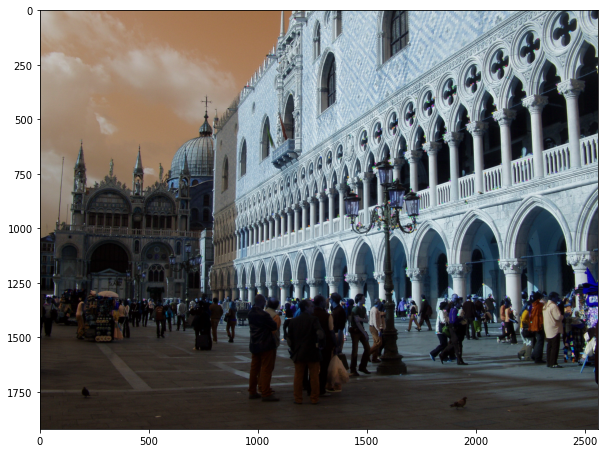

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,12))
plt.imshow(img2)
plt.show()

In [ ]:
expanded_radius = []
for key,radius in keypoints:
    expand_r = int(int(radius/2)*3.2)
    expanded_radius.append(expand_r)

In [ ]:
cords = []
for cord,radius in keypoints:
    cords.append(cord)

In [ ]:
path = "gdrive/My Drive/copy_detection/ours_croped_scaled/20.jpg"

all_hash_values = []
for cord,ex_radius in zip(cords,expanded_radius):
    slices = get_blocks(cord,radius,path)
#     print(len(slices))
    if len(slices) == 25 or len(slices) == 20:
        grey_intensities = np.round(np.array([np.mean(i) for i in slices]).reshape(5,int(len(slices)/5)),2)    
    else:
        grey_intensities = np.round(np.array([np.mean(i) for i in slices]).reshape(4,int(np.ceil(16/5))),2)
    hash_val = get_hash_embedding(grey_intensities)
    all_hash_values.append(hash_val)

In [ ]:
len(all_hash_values) #324 hash points for our querry image

1500

In [ ]:
# import scipy
# import random
# random.seed(101)

# from scipy.cluster.vq import kmeans,vq #vq stands for vector quantization
# k= 100
# voc,variance=kmeans(keypoint_feat,k,50) #all keypoint features of all images

q_features=np.zeros((1,k),"float32")    
words,distance=vq(keypoint_feat,voc1) #all keypoint features of single image
for w in words:
    q_features[0][w]+=1

In [ ]:
import sys
import numpy 
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
q_features #It returns a vector of length n_clusters with its frequency count

array([[483.,  93.,   0.,   0.,   0.,  58.,  13.,   2.,   3.,   2.,   6.,
         14.,   8.,  16.,   6.,  86.,  12.,   0.,   0.,   7.,   0.,   5.,
         23.,   0.,   0.,  64.,   0.,   6.,   8.,  45.,   7.,   0.,   0.,
          4.,  35.,  12.,  14.,  16.,   0.,   0.,  13.,  24.,   0.,  78.,
          2.,  10.,  11.,   0.,   0.,   0.,  10.,  35.,   9.,   0.,  33.,
          0.,   0.,   9.,   0.,   0.,   0.,  75.,   8.,  37.,   0.,  19.,
          0.,  65.,  13.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]], dtype=float32)

### Final: data base image information

In [ ]:
img_feat.shape

(42000, 256)

In [ ]:
total_images_features[0].shape #local CNN features

(1500, 256)

In [ ]:
len(total_images_hash_values)

28

In [ ]:
len(total_images_hash_values[0]) #hash embeddings

1500

In [ ]:
im_features.shape #VBOW

(28, 100)

In [ ]:
voc1.shape #47 clusters

(79, 256)

### Final: Querry image information

In [ ]:
keypoint_feat.shape #Local CNN Features

(1500, 256)

In [ ]:
len(all_hash_values) #hash embeddings

1500

In [ ]:
q_features

array([[483.,  93.,   0.,   0.,   0.,  58.,  13.,   2.,   3.,   2.,   6.,
         14.,   8.,  16.,   6.,  86.,  12.,   0.,   0.,   7.,   0.,   5.,
         23.,   0.,   0.,  64.,   0.,   6.,   8.,  45.,   7.,   0.,   0.,
          4.,  35.,  12.,  14.,  16.,   0.,   0.,  13.,  24.,   0.,  78.,
          2.,  10.,  11.,   0.,   0.,   0.,  10.,  35.,   9.,   0.,  33.,
          0.,   0.,   9.,   0.,   0.,   0.,  75.,   8.,  37.,   0.,  19.,
          0.,  65.,  13.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]], dtype=float32)

In [ ]:
sum(q_features[0]) 

1500.0

### Inverted index Creation 

In [ ]:
# #generating filepath:im_features in dictionary

image_vocab = {} #filepath,vocab
for file_name,im_feature in zip(images,im_features):
    image_vocab[file_name] = list(im_feature)

In [ ]:
from collections import defaultdict
inverted_indx = defaultdict(list) 


for image_id,feature,kp in zip(list(range(len(images))),im_features,database_words): #101.jpg, im_feature,430kp
    for indx,count in enumerate(feature): #for every feature in im_features
        if int(count)>0: #if fequency value is >0
            # no = int(image_id.split(".")[0]) # image no
            hashes = [{ind:total_images_hash_values[image_id][ind]}  for ind,j in enumerate(kp) if j == indx]
            inverted_indx[indx].append([image_id,hashes])

#### inverted_index for querry image

In [ ]:
#for querry image
#generating filepath:im_features in dictionary

q_image = ['20.jpg']
q_image_vocab = {} #filepath,vocab
for file_name,q_feature in zip(q_image,q_features):
    q_image_vocab[file_name] = list(q_feature)


In [ ]:
from collections import defaultdict
q_inverted_indx = defaultdict(list) 


for indx,count in enumerate(q_features[0]): #for every feature in im_features
    if int(count)>0: #if fequency value is >0
        no = int(q_image[0].split(".")[0]) # image no
        hashes = [{ind:all_hash_values[ind]}  for ind,j in enumerate(words) if j == indx]
        q_inverted_indx[indx].append([q_image[0],hashes])

In [ ]:
import math
dict1={}
for i in range(0,len(im_features)):
  apple=im_features[i]
  for index,value in enumerate(apple):
    if value > 0:
      if index in dict1:
        dict1[index]=dict1[index] +1
      else:
        dict1[index]=1
for key,value in dict1.items():
  IDF= math.log(len(im_features) / value)
  dict1[key]=IDF
idf_dict=dict1

In [ ]:
inverted_indx[1][0][0] #cluster1, first images out of 6 images,imagename
inverted_indx[1][0][1] #cluster1, first images out of 6 images, kp and hash
inverted_indx[1][0][1][0].values() #first hash values

dict_values([['00000000', '00111100', '00111110', '00000000', '10001110', '01000000', '00110111', '10000000', '00001111', '10011100', '11111111', '10000000', '00000010', '00000000', '00100011', '10000000']])

In [ ]:
from typing import List
def distance_hash_sequence(q_hash_sequence:List[str],d_hash_sequence:List[str])->float:
    M = 4
    N = 4
    distance = 0
    #calculating the distance
    for index in range(0,len(q_hash_sequence)):
        for q_hash_sequence_bit,d_hash_sequence_bit in zip(list(q_hash_sequence[index]),list(d_hash_sequence[index])):
            distance+=abs(int(q_hash_sequence_bit)-int(d_hash_sequence_bit))/(M*N*8)
    return distance

In [ ]:
dist_t = 0.35

final_res = {}
for i in q_inverted_indx.keys():                     #querry clusters
    for j in inverted_indx.keys():                   #database clusters
        if i==j:
            images = len(inverted_indx[i])#6 images to compare
            img_count = {}
            for image in range(images):             #in each image
                mini = min(len(inverted_indx[i][image][1]),len(q_inverted_indx[i][0][1])) #which one has less len
                for hs in range(mini):
                    a = list(q_inverted_indx[i][0][1][hs].values())[0]
                    b = list(inverted_indx[i][image][1][hs].values())[0]
                    dist = distance_hash_sequence(a,b)
                    if dist < dist_t:
                        if inverted_indx[i][image][0] not in img_count:
                            img_count[inverted_indx[i][image][0]]=0
                        if inverted_indx[i][image][0] in img_count:
                            img_count[inverted_indx[i][image][0]]+=1
    final_res[i]=img_count

In [ ]:
file = {}
for vbw  in q_inverted_indx.keys():
    for val,key in final_res[vbw].items():
#         print(val,key*IDF_database[vbw][0])
        if val not in file:
            file[val] = key*idf_dict[vbw]
        if val in file:
            file[val]+= key*idf_dict[vbw]
        

In [ ]:
sorted(file.items(), key=lambda item: item[1],  reverse=True)

[(19, -7608.7599999999975),
 (18, -7293.529999999997),
 (16, -7288.759999999999),
 (17, -6466.179999999998),
 (13, -6208.24),
 (9, -5947.609999999999),
 (8, -5898.530000000001),
 (10, -5879.44),
 (11, -5862.4299999999985),
 (12, -5644.439999999998),
 (15, -5521.319999999997),
 (24, -5121.72),
 (14, -5066.56),
 (26, -5044.840000000001),
 (27, -4864.83),
 (21, -4851.340000000001),
 (25, -4531.28),
 (20, -4352.679999999999),
 (5, -4331.699999999998),
 (23, -4241.41),
 (22, -4110.21),
 (3, -3135.29),
 (2, -3108.08),
 (6, -116.19999999999999),
 (0, -104.58),
 (7, -37.03),
 (4, -23.24)]

In [ ]:
files_path="/content/gdrive/My Drive/pixy_final_repo/5/"
val =sorted([int(i.split(".")[0]) for i in os.listdir(files_path)]) #os.listdir wont give you file order
images = [str(i)+".jpg" for i in val] #getting files in order

In [ ]:
for i,j in enumerate(images):
  print(i,j)